In [9]:
import pandas as pd
import numpy as np
import random # seed
from sklearn.utils import resample
from sklearn import preprocessing

import os

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# modules to interpret the training result
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

# silent the warning 
import warnings
warnings.filterwarnings('ignore')

# ensure reproducibility
random.seed(10)
np.random.seed(10)


In [2]:
CICDDoS2019_binary = pd.read_csv(r'balanced_CIC-DDoS2019_binary.csv')
CICDDoS2019_binary = CICDDoS2019_binary.sample(frac=0.1).reset_index(drop=True)
CICDDoS2019_binary.shape


(30000, 68)

In [3]:
CICDDoS2019_binary_X = CICDDoS2019_binary.drop('Label', axis=1).copy()
CICDDoS2019_binary_y = CICDDoS2019_binary['Label'].copy()


In [4]:
X_columns = CICDDoS2019_binary_X.columns
CICDDoS2019_binary_X = StandardScaler().fit_transform(CICDDoS2019_binary_X)


In [5]:
%%time

rfc = RandomForestClassifier()
rfc.fit(CICDDoS2019_binary_X, CICDDoS2019_binary_y)

CPU times: user 2.14 s, sys: 32.6 ms, total: 2.17 s
Wall time: 2.19 s


RandomForestClassifier()

Top features: 
                             importance score
feature                                      
Min Packet Length                       0.149
Fwd Packet Length Mean                  0.085
Avg Fwd Segment Size                    0.080
Packet Length Mean                      0.077
Fwd Packet Length Min                   0.072
Inbound                                 0.054
Bwd Packets/s                           0.051
Average Packet Size                     0.046
Fwd Packet Length Max                   0.035
Init_Win_bytes_forward                  0.030
Bwd IAT Mean                            0.028
URG Flag Count                          0.024
Bwd Header Length                       0.024
Total Backward Packets                  0.022
Protocol                                0.021
Max Packet Length                       0.020
ACK Flag Count                          0.019
Bwd IAT Max                             0.016
Subflow Fwd Bytes                       0.016
Total Length of Fwd

<AxesSubplot:xlabel='feature'>

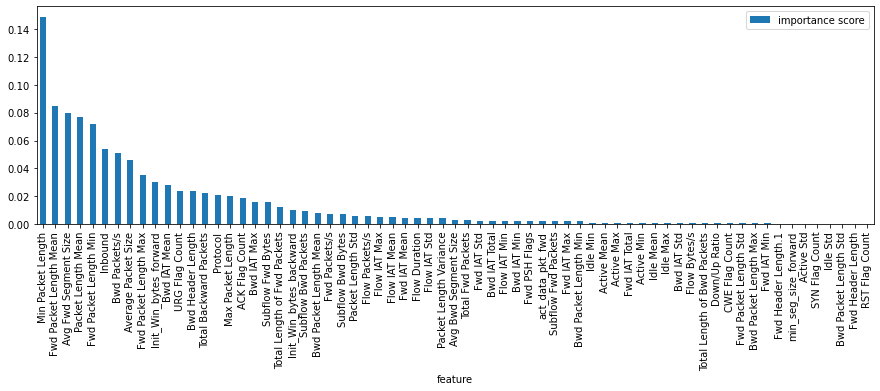

In [6]:
#extract the importance score
score = np.round(rfc.feature_importances_, 3)
importance = pd.DataFrame({'feature': X_columns,
                             'importance score': score})
importance = importance.sort_values('importance score', ascending=False).set_index('feature')

print(f"Top features: \n{importance[:30]}")

plt.rcParams['figure.figsize'] = (15, 4)
importance.plot.bar()

In [10]:
def save_feature(features: pd.Series, dataset_name: str, algorithm: str, tag: str = ""):
    
    feature_count = features.shape[0]

    if not(tag == ""):
        tag = "_" + tag
    
    directory = 'Dataset/features_selected'
    file_name = f"{dataset_name}_{algorithm}_{feature_count}{tag}"
    
    # create directory to save the file
    os.makedirs(directory, exist_ok=True)
    
    features.to_csv(f"{directory}/{file_name}.csv", index=False, columns=None)

    print(f"The features have been saved in {directory}/{file_name}.csv")

In [11]:
# save the ranking of the features in a CSV file
features = pd.Series(importance.index[:30], dtype='str')
save_feature(features=features,
            dataset_name='CICDDoS2019_Binary', 
            algorithm='RandomForestClassifier')

The features have been saved in Dataset/features_selected/CICDDoS2019_Binary_RandomForestClassifier_30.csv


In [19]:
columns = features.tolist() +  ['Label']

CICDDoS2019_binary = CICDDoS2019_binary[columns]
CICDDoS2019_binary.shape

(30000, 31)

In [20]:

CICDDoS2019_binary_X = CICDDoS2019_binary.drop('Label', axis=1).copy()
CICDDoS2019_binary_y = CICDDoS2019_binary['Label'].copy()

CICDDoS2019_binary_train_X, CICDDoS2019_binary_test_X, CICDDoS2019_binary_train_y, CICDDoS2019_binary_test_y = train_test_split(CICDDoS2019_binary_X, CICDDoS2019_binary_y, test_size=0.3)



In [23]:
# define ML models without optimized hyperparameter
models = {
    'K-Nearest Neighbour': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(n_jobs=-1),
    'Naive Bayes': GaussianNB(),
    'Artificial Neural Network': MLPClassifier(hidden_layer_sizes=(40), max_iter=500),
    'Deep Neural Network': MLPClassifier(hidden_layer_sizes=(12, 12, 12), max_iter=500),
    'XGBoost': xgb.XGBClassifier(eval_metric = 'logloss')
}

In [24]:

feature_set = []
scaler = StandardScaler()
scores = []

for feature in features:
    feature_set.append(feature)
    print(f"Added feature {len(feature_set)} ({feature})...")

    train_X = CICDDoS2019_binary_train_X[feature_set]
    test_X = CICDDoS2019_binary_test_X[feature_set]

    # Scale the dataset
    train_X_scaled = scaler.fit_transform(train_X)
    test_X_scaled = scaler.transform(test_X)

    score_temp = [len(feature_set)]

    for model in models:
        clf = models[model]
        clf.fit(train_X_scaled, CICDDoS2019_binary_train_y)  # Convert y to 1D array

        prediction = clf.predict(test_X_scaled)
        accuracy = metrics.accuracy_score(CICDDoS2019_binary_test_y, prediction)  # Convert y to 1D array

        score_temp.append(accuracy)

    scores.append(score_temp)

scores = np.array(scores)


Added feature 1 (Min Packet Length)...
Added feature 2 (Fwd Packet Length Mean)...
Added feature 3 (Avg Fwd Segment Size)...
Added feature 4 (Packet Length Mean)...
Added feature 5 (Fwd Packet Length Min)...
Added feature 6 (Inbound)...
Added feature 7 (Bwd Packets/s)...
Added feature 8 (Average Packet Size)...
Added feature 9 (Fwd Packet Length Max)...
Added feature 10 (Init_Win_bytes_forward)...
Added feature 11 (Bwd IAT Mean)...
Added feature 12 (URG Flag Count)...
Added feature 13 (Bwd Header Length)...
Added feature 14 (Total Backward Packets)...
Added feature 15 (Protocol)...
Added feature 16 (Max Packet Length)...
Added feature 17 (ACK Flag Count)...
Added feature 18 (Bwd IAT Max)...
Added feature 19 (Subflow Fwd Bytes)...
Added feature 20 (Total Length of Fwd Packets)...
Added feature 21 (Init_Win_bytes_backward)...
Added feature 22 (Subflow Bwd Packets)...
Added feature 23 (Bwd Packet Length Mean)...
Added feature 24 (Fwd Packets/s)...
Added feature 25 (Subflow Bwd Bytes)...
A

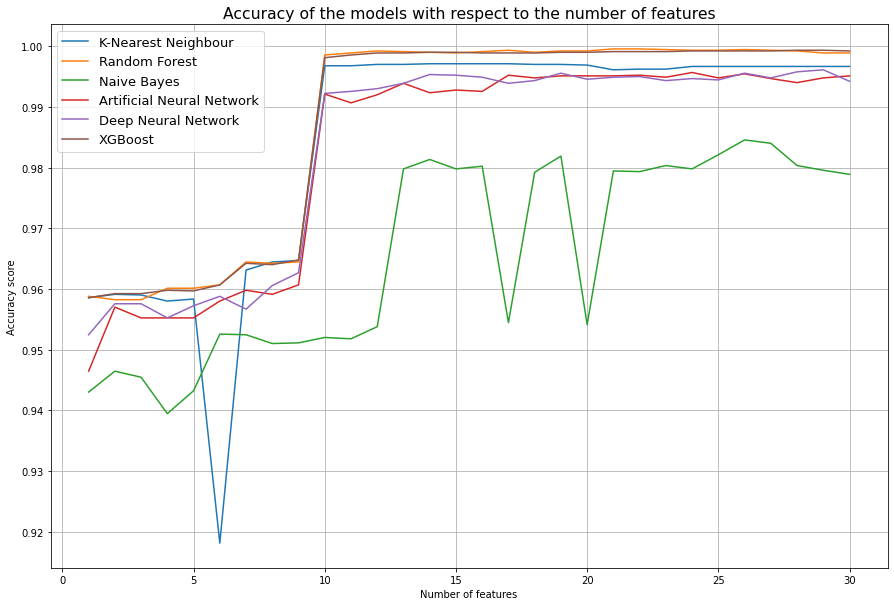

In [25]:
plt.figure(figsize=(15, 10))
for index, model in enumerate(models):
    plt.plot(scores.T[0], scores.T[index + 1], label=model)

plt.rcParams.update({'font.size': 13})
plt.title('Accuracy of the models with respect to the number of features')
plt.xlabel('Number of features')
plt.ylabel('Accuracy score')
plt.legend()
plt.grid()
plt.show()